런타임 유형 변경을 통해, GPU 세션으로 실행하는 것을 잊지 마십시오.

# 베이스 import

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# Base libraries
import os
import random
import cv2

# Keras libraries
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model

print(tf.__version__)

2.3.0


# 유틸

In [4]:
def save_model(model_name: str, model: keras.models.Model):
    model_json = model.to_json()
    with open(model_name, "w") as json_file:
        json_file.write(model_json)

from keras.models import model_from_json
from typing import Optional

In [5]:
def load_model(
    model_name: str, with_weights_path: Optional[str] = None
) -> keras.models.Model:
    json_file = open(model_name, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    if with_weights_path:
        model.load_weights(with_weights_path)
    return model

In [4]:
# # 구글 드라이브 import
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)

# import os
# gdrive_path = os.path.join("/gdrive", "My Drive", "lecture", "resources")

# Dataset

## 다운로드

In [6]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

In [7]:
# cv2가 처리하지 못하는 파일 삭제

!rm -f images/Egyptian_Mau_177.jpg
!rm -f annotations/trimaps/Egyptian_Mau_177.png

!rm -f images/Egyptian_Mau_191.jpg
!rm -f annotations/trimaps/Egyptian_Mau_191.png

!rm -f images/Egyptian_Mau_139.jpg
!rm -f annotations/trimaps/Egyptian_Mau_139.png

!rm -f images/Egyptian_Mau_145.jpg
!rm -f annotations/trimaps/Egyptian_Mau_145.png

!rm -f images/Egyptian_Mau_167.jpg
!rm -f annotations/trimaps/Egyptian_Mau_167.png

!rm -f images/Abyssinian_34.jpg
!rm -f annotations/trimaps/Abyssinian_34.png

# list.txt에 존재하지 않음
!rm -f images/Egyptian_Mau_41.jpg
!rm -f annotations/trimaps/Egyptian_Mau_41.png

!rm -f images/Bombay_220.jpg
!rm -f annotations/trimaps/Bombay_220.png

!rm -f images/english_cocker_spaniel_163.jpg
!rm -f annotations/trimaps/english_cocker_spaniel_163.png

!rm -f images/Abyssinian_82.jpg
!rm -f annotations/trimaps/Abyssinian_82.png

!rm -f images/Bombay_189.jpg
!rm -f images/Bombay_69.jpg
!rm -f images/Bombay_209.jpg
!rm -f images/english_cocker_spaniel_164.jpg
!rm -f images/Siamese_203.jpg
!rm -f images/Egyptian_Mau_202.jpg
!rm -f images/keeshond_59.jpg
!rm -f images/newfoundland_154.jpg
!rm -f images/Bombay_92.jpg
!rm -f images/newfoundland_152.jpg
!rm -f images/Bombay_22.jpg
!rm -f images/Bombay_32.jpg
!rm -f images/Bombay_217.jpg
!rm -f images/Egyptian_Mau_183.jpg
!rm -f images/Egyptian_Mau_129.jpg
!rm -f images/Bombay_206.jpg
!rm -f images/newfoundland_153.jpg
!rm -f images/Bombay_192.jpg
!rm -f images/Egyptian_Mau_71.jpg
!rm -f images/Bombay_210.jpg
!rm -f images/Bombay_85.jpg
!rm -f images/Bombay_99.jpg
!rm -f images/staffordshire_bull_terrier_22.jpg
!rm -f images/boxer_82.jpg
!rm -f images/staffordshire_bull_terrier_2.jpg
!rm -f images/Bombay_11.jpg
!rm -f images/Bombay_190.jpg
!rm -f images/english_cocker_spaniel_162.jpg
!rm -f images/newfoundland_155.jpg
!rm -f images/english_cocker_spaniel_179.jpg
!rm -f images/Bombay_203.jpg




# 그 외 에러?
!rm -f images/Bengal_85.jpg
!rm -f annotations/trimaps/Bengal_85.png

!rm -f images/Egyptian_Mau_47.jpg
!rm -f annotations/trimaps/Egyptian_Mau_47.png

# 기초문제

## Semantic Segmentation

### 준비

In [9]:
batch_size = 32
seed = 42

In [8]:
image_files = os.listdir("images")
image_names = list(map(lambda v: v[:-4], image_files))

random.seed(seed)
random.shuffle(image_names)

split = int(0.95 * len(image_names))
train_image_names = image_names[0:split]
test_image_names  = image_names[split:]

val_split = int(0.9 * len(train_image_names))
val_image_names = train_image_names[val_split:]
train_image_names = train_image_names[0:val_split]

In [9]:
import toolz
import numpy as np

def img_mask_generator(img_path, mask_path, image_files, mask_files, batch_size=1, target_size=(256, 256)):
  total_file_num = len(image_files)
  index = -1
  while True:
    index = 0 if index > ((total_file_num // batch_size) - 2) else index+1
    img_batch = []
    mask_batch = []
    
    for i in range(batch_size):
      img = cv2.imread(os.path.join(img_path, image_files[batch_size*index+i]), cv2.IMREAD_COLOR)
      img = cv2.resize(img, target_size, interpolation=cv2.INTER_NEAREST)

      img = img / 255.

      img_batch.append(img)
      
      mask = cv2.imread(os.path.join(mask_path, mask_files[batch_size*index+i]), cv2.IMREAD_GRAYSCALE)
      mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

      mask[mask >= 2] = 0
      mask[mask != 0] = 1
      
      mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
      mask_batch.append(mask)

    yield np.array(img_batch), np.array(mask_batch)

with_ext = lambda v, ext: "{}.{}".format(v, ext)

In [10]:
train_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), train_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), train_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

val_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), val_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), val_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

test_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), test_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), test_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

In [11]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

### 문제1. 다음의 U-Net 모델을 완성시키세요.

* (가산) optimizer, 필터 및 구조를 바꾸어가며, 높은 mean iou를 달성하도록 시도하십시오.
* 더 높은 mean iou를 달성하기 위해, 위에서 제시하는 모든 함수를 바꾸어도 됩니다.
* (기본) 내용을 따라오지 못했다면, 기존의 코드를 복사해 제출합니다.

In [12]:
# 기존 코드 반영 - model

def unet(input_size = (256, 256, 3)):
    x = Input(input_size)
    inputs = x


    # down sampling 
    f = 8
    layers = []
    
    for i in range(0, 6):
      x = Conv2D(f, 3, activation='relu', padding='same') (x)
      x = Conv2D(f, 3, activation='relu', padding='same') (x)
      layers.append(x)
      x = MaxPooling2D() (x)
      f = f*2
    ff2 = 64 
    
    # bottleneck 
    j = len(layers) - 1
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
    # upsampling 
    for i in range(0, 5):
      ff2 = ff2//2
      f = f // 2 
      x = Conv2D(f, 3, activation='relu', padding='same') (x)
      x = Conv2D(f, 3, activation='relu', padding='same') (x)
      x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
      x = Concatenate(axis=3)([x, layers[j]])
      j = j -1 
      
    
    # classification 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)

    outputs = Conv2D(1, 1, activation='sigmoid') (x)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
    return model

### 실행

In [13]:
model = unet()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 8)  0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [61]:
# 필터 및 구조 변경 - model_1
# reference : https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5

def unet_model_1(input_size = (256, 256, 3)):
    x = Input(input_size)
    inputs = x
    f = 8

    conv1 = Conv2D(f * 1, 3, activation="relu", padding="same")(inputs)
    conv1 = Conv2D(f * 1, 3, activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(f * 2, 3, activation="relu", padding="same")(pool1)
    conv2 = Conv2D(f * 2, 3, activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(f * 4, 3, activation="relu", padding="same")(pool2)
    conv3 = Conv2D(f * 4, 3, activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    #pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(f * 8, 3, activation="relu", padding="same")(pool3)
    conv4 = Conv2D(f * 8, 3 , activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    #pool4 = Dropout(0.5)(pool4)
    
    conv5 = Conv2D(f * 16, 3, activation="relu", padding="same")(pool4)
    conv5 = Conv2D(f * 16, 3 , activation="relu", padding="same")(conv5)
    pool5 = MaxPooling2D((2, 2))(conv5)
    #pool5 = Dropout(0.5)(pool5)

    # Middle
    convm = Conv2D(f * 32,3, activation="relu", padding="same")(pool5)
    convm = Conv2D(f * 32,3, activation="relu", padding="same")(convm)
    convm = Dropout(0.5)(convm)

    deconv5 = Conv2DTranspose(f * 16,3, strides=2, padding="same")(convm)
    uconv5 = Concatenate()([deconv5, conv5])
    uconv5 = Dropout(0.5)(uconv5)
    uconv5 = Conv2D(f * 16,3, activation="relu", padding="same")(uconv5)
    uconv5 = Conv2D(f * 16,3, activation="relu", padding="same")(uconv5)

    deconv4 = Conv2DTranspose(f * 8,3, strides=2, padding="same")(uconv5)
    uconv4 = Concatenate()([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(f * 8,3, activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(f * 8,3, activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(f * 4, 3, strides=2, padding="same")(uconv4)
    uconv3 = Concatenate()([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(f * 4,3, activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(f * 4,3, activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(f * 2, 3, strides=2, padding="same")(uconv3)
    uconv2 = Concatenate()([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(f * 2, 3, activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(f * 2, 3, activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(f * 1, 3, strides=2, padding="same")(uconv2)
    uconv1 = Concatenate()([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(f * 1, 3, activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(f * 1, 3, activation="relu", padding="same")(uconv1)
    
    outputs = Conv2D(1, 1, activation='sigmoid') (uconv1)
    
    model_1 = Model(inputs=[inputs], outputs=[outputs])
    model_1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [mean_iou])
  
    return model_1

In [62]:
model_1 = unet_model_1()
model_1.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_312 (Conv2D)             (None, 256, 256, 8)  224         input_20[0][0]                   
__________________________________________________________________________________________________
conv2d_313 (Conv2D)             (None, 256, 256, 8)  584         conv2d_312[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_85 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_313[0][0]                 
______________________________________________________________________________________

In [63]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

val_image_list = list(map(lambda v: with_ext(v, "jpg"), val_image_names))

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        # print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        # choose a random test image and preprocess
        path = np.random.choice(val_image_list)
        img = cv2.imread(f'images/{path}')
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
        img = img / 255.

        target_mask = cv2.imread(os.path.join("annotations", "trimaps", "{}.png".format(path[:-4])))
        target_mask = cv2.resize(target_mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        target_mask[target_mask >= 2] = 0
        target_mask[target_mask != 0] = 1
        
        # predict the mask 
        pred = model.predict(np.expand_dims(img, 0))
        #pred_1 = model_1.predict(np.expand_dims(img, 0))        

        # mask post-processing 
        msk = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 

        # show the mask and the segmented image 
        img = img.astype(np.float32) 
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        combined = np.concatenate([rgb_img, msk, rgb_img * msk, target_mask], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [40]:
# 에포크를 10으로 하지 않고 늘려서 해도 상관없음

Epoch 1/10
196/196 [==============================] - ETA: 0s - loss: 0.4288 - mean_iou: 0.4602

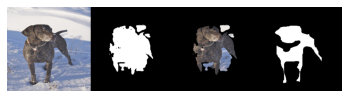

196/196 [==============================] - 51s 258ms/step - loss: 0.4288 - mean_iou: 0.4602 - val_loss: 0.4027 - val_mean_iou: 0.4694
Epoch 2/10
196/196 [==============================] - ETA: 0s - loss: 0.4059 - mean_iou: 0.4972

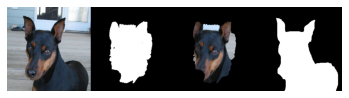

196/196 [==============================] - 51s 258ms/step - loss: 0.4059 - mean_iou: 0.4972 - val_loss: 0.3701 - val_mean_iou: 0.5345
Epoch 3/10
196/196 [==============================] - ETA: 0s - loss: 0.3711 - mean_iou: 0.5555

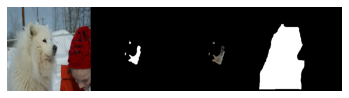

196/196 [==============================] - 51s 260ms/step - loss: 0.3711 - mean_iou: 0.5555 - val_loss: 0.4029 - val_mean_iou: 0.4468
Epoch 4/10
196/196 [==============================] - ETA: 0s - loss: 0.3350 - mean_iou: 0.6009

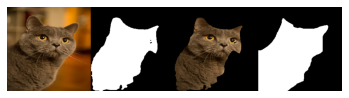

196/196 [==============================] - 51s 260ms/step - loss: 0.3350 - mean_iou: 0.6009 - val_loss: 0.2905 - val_mean_iou: 0.6403
Epoch 5/10
196/196 [==============================] - ETA: 0s - loss: 0.3018 - mean_iou: 0.6447

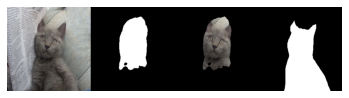

196/196 [==============================] - 51s 261ms/step - loss: 0.3018 - mean_iou: 0.6447 - val_loss: 0.2670 - val_mean_iou: 0.6609
Epoch 6/10
196/196 [==============================] - ETA: 0s - loss: 0.2757 - mean_iou: 0.6737

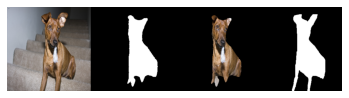

196/196 [==============================] - 51s 260ms/step - loss: 0.2757 - mean_iou: 0.6737 - val_loss: 0.2580 - val_mean_iou: 0.6688
Epoch 7/10
196/196 [==============================] - ETA: 0s - loss: 0.2569 - mean_iou: 0.6968

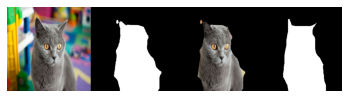

196/196 [==============================] - 51s 260ms/step - loss: 0.2569 - mean_iou: 0.6968 - val_loss: 0.2593 - val_mean_iou: 0.6822
Epoch 8/10
196/196 [==============================] - ETA: 0s - loss: 0.2399 - mean_iou: 0.7166

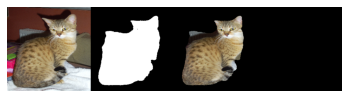

196/196 [==============================] - 51s 262ms/step - loss: 0.2399 - mean_iou: 0.7166 - val_loss: 0.2342 - val_mean_iou: 0.7098
Epoch 9/10
196/196 [==============================] - ETA: 0s - loss: 0.2234 - mean_iou: 0.7355

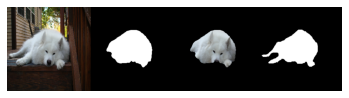

196/196 [==============================] - 52s 264ms/step - loss: 0.2234 - mean_iou: 0.7355 - val_loss: 0.2643 - val_mean_iou: 0.6646
Epoch 10/10
196/196 [==============================] - ETA: 0s - loss: 0.2116 - mean_iou: 0.7494

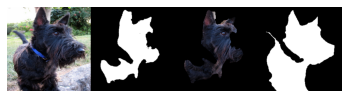

196/196 [==============================] - 52s 266ms/step - loss: 0.2116 - mean_iou: 0.7494 - val_loss: 0.2481 - val_mean_iou: 0.6768


In [43]:
# 기존 코드 반영 - model
train_steps = len(train_image_names) // batch_size
val_steps = len(val_image_names) // batch_size

history = model.fit(
    train_batch_generator,
    epochs = 10,
    steps_per_epoch = train_steps,
    validation_data = val_batch_generator, 
    validation_steps = val_steps,
    callbacks = build_callbacks(), verbose = 1)


Epoch 1/10
196/196 [==============================] - ETA: 0s - loss: 0.4982 - mean_iou: 0.2668

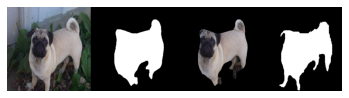

196/196 [==============================] - 52s 265ms/step - loss: 0.4982 - mean_iou: 0.2668 - val_loss: 0.4163 - val_mean_iou: 0.4011
Epoch 2/10
196/196 [==============================] - ETA: 0s - loss: 0.4028 - mean_iou: 0.5092

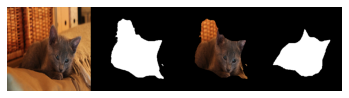

196/196 [==============================] - 51s 260ms/step - loss: 0.4028 - mean_iou: 0.5092 - val_loss: 0.3691 - val_mean_iou: 0.5099
Epoch 3/10
196/196 [==============================] - ETA: 0s - loss: 0.3579 - mean_iou: 0.5704

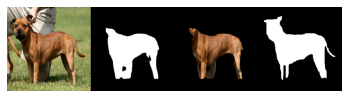

196/196 [==============================] - 51s 261ms/step - loss: 0.3579 - mean_iou: 0.5704 - val_loss: 0.3212 - val_mean_iou: 0.5764
Epoch 4/10
196/196 [==============================] - ETA: 0s - loss: 0.3169 - mean_iou: 0.6244

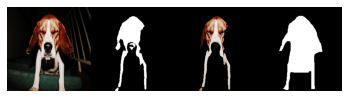

196/196 [==============================] - 51s 263ms/step - loss: 0.3169 - mean_iou: 0.6244 - val_loss: 0.2947 - val_mean_iou: 0.6343
Epoch 5/10
196/196 [==============================] - ETA: 0s - loss: 0.2860 - mean_iou: 0.6593

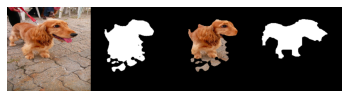

196/196 [==============================] - 52s 265ms/step - loss: 0.2860 - mean_iou: 0.6593 - val_loss: 0.2807 - val_mean_iou: 0.6150
Epoch 6/10
196/196 [==============================] - ETA: 0s - loss: 0.2656 - mean_iou: 0.6831

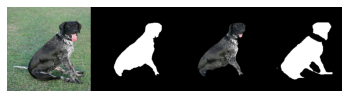

196/196 [==============================] - 52s 264ms/step - loss: 0.2656 - mean_iou: 0.6831 - val_loss: 0.2783 - val_mean_iou: 0.6486
Epoch 7/10
196/196 [==============================] - ETA: 0s - loss: 0.2518 - mean_iou: 0.7005

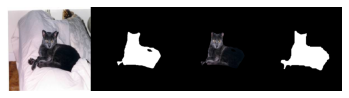

196/196 [==============================] - 52s 264ms/step - loss: 0.2518 - mean_iou: 0.7005 - val_loss: 0.2568 - val_mean_iou: 0.6800
Epoch 8/10
196/196 [==============================] - ETA: 0s - loss: 0.2338 - mean_iou: 0.7213

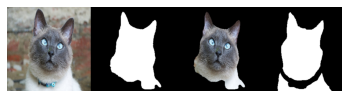

196/196 [==============================] - 52s 263ms/step - loss: 0.2338 - mean_iou: 0.7213 - val_loss: 0.2626 - val_mean_iou: 0.6873
Epoch 9/10
196/196 [==============================] - ETA: 0s - loss: 0.2241 - mean_iou: 0.7337

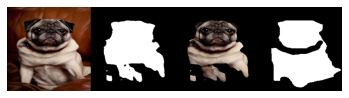

196/196 [==============================] - 52s 263ms/step - loss: 0.2241 - mean_iou: 0.7337 - val_loss: 0.2360 - val_mean_iou: 0.7019
Epoch 10/10
196/196 [==============================] - ETA: 0s - loss: 0.2185 - mean_iou: 0.7387

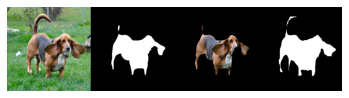

196/196 [==============================] - 52s 264ms/step - loss: 0.2185 - mean_iou: 0.7387 - val_loss: 0.2534 - val_mean_iou: 0.6879


In [64]:
# 필터 및 구조 변경 - model_1

train_steps = len(train_image_names) // batch_size
val_steps = len(val_image_names) // batch_size

history = model_1.fit(
    train_batch_generator,
    epochs = 10,
    steps_per_epoch = train_steps,
    validation_data = val_batch_generator, 
    validation_steps = val_steps,
    callbacks = build_callbacks(), verbose = 1)

In [60]:
test_steps = len(test_image_names) // batch_size
test_loss, test_mean_iou = model.evaluate(test_batch_generator, steps=test_steps, verbose=2)
print('기존 U-net코드 모델 테스트 정확도:', test_mean_iou)

test_steps = len(test_image_names) // batch_size
test_loss, test_mean_iou = model_1.evaluate(test_batch_generator, steps=test_steps, verbose=2)
print('모델1 테스트 정확도:', test_mean_iou)

11/11 - 2s - loss: 0.2422 - mean_iou: 0.6953
기존 U-net코드 모델 테스트 정확도: 0.6953091025352478
11/11 - 2s - loss: 0.2226 - mean_iou: 0.7135
모델1 테스트 정확도: 0.713509202003479


## Classification

### 준비

In [65]:
fashion_mnist = keras.datasets.fashion_mnist

(fashion_train_images, fashion_train_labels), (fashion_test_images, fashion_test_labels) = fashion_mnist.load_data()

fashion_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fashion_train_images = fashion_train_images / 255.0
fashion_test_images = fashion_test_images / 255.0               

4423680/4422102 [==============================] - 0s 0us/step


In [66]:
fashion_train_labels.shape

fashion_train_labels[0]

9

### 문제2. 다음의 CNN 기반 Classification을 완성시키세요.

* (가산) optimizer, 필터 및 구조를 바꾸어가며, 높은 accuracy를 달성하도록 시도하십시오.
* (기본) 내용을 따라오지 못했다면, 기존의 코드를 복사해 제출합니다.

In [67]:
# 기존 NN코드 model
def cnn_classification_model():
  input = keras.layers.Input((28, 28, 1))

  flatten = keras.layers.Flatten()(input)
  
  dense_3 = keras.layers.Dense(20, activation='softmax')(flatten)
  dense_3 = keras.layers.Dense(30, activation='softmax')(dense_3)
  dense_3 = keras.layers.Dense(20, activation='softmax')(dense_3)
    
  #dense_3 = keras.layers.Dense(10, activation='softmax')(flatten)
  
  dense_3 = keras.layers.Dense(10, activation='softmax')(dense_3)

  
  return keras.models.Model(inputs=[input], outputs=[dense_3])

In [68]:
classification_model = cnn_classification_model()
classification_model.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                15700     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
Total params: 17,160
Trainable params: 17,160
Non-trainable params: 0
_________________________________________________

### 실행

In [70]:
# CNN기반 Classification model
# reference : https://sanjayasubedi.com.np/deeplearning/keras-example-cnn-with-fashion-mnist-dataset/

def cnn_classification_model_1():
  input = keras.layers.Input((28, 28, 1))

  #flatten = keras.layers.Flatten()(input)

  x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(input)
  x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.25)(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(units=128, activation='relu')(x)
  x = Dropout(0.2)(x)

  dense_3 = keras.layers.Dense(10, activation='softmax')(x)

  
  return keras.models.Model(inputs=[input], outputs=[dense_3])

In [71]:
classification_model_1 = cnn_classification_model_1()
classification_model_1.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_335 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_336 (Conv2D)          (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)             

In [75]:
# 기존 NN모델 컴파일
classification_model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


# CNN classification 모델 컴파일
classification_model_1.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [76]:
BATCH_SIZE = 32
fashion_num_train_examples = len(fashion_train_images)

import math

print("< 기존 NN모델 >")
fashion_history = classification_model.fit(fashion_train_images, fashion_train_labels, epochs=10, batch_size=BATCH_SIZE, steps_per_epoch=math.ceil(fashion_num_train_examples/BATCH_SIZE))

print("< CNN 기반 classification 모델 >")
fashion_history = classification_model_1.fit(fashion_train_images, fashion_train_labels, epochs=10, batch_size=BATCH_SIZE, steps_per_epoch=math.ceil(fashion_num_train_examples/BATCH_SIZE))

< 기존 NN모델 >
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5668 - accuracy: 0.8035
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5332 - accuracy: 0.8112
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5027 - accuracy: 0.8222
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4749 - accuracy: 0.8390
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4445 - accuracy: 0.8579
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4238 - accuracy: 0.8656
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4118 - accuracy: 0.8693
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3975 - accuracy: 0.8717
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3901 - accuracy: 0.8757
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step -

In [77]:
fashion_test_loss, fashion_test_acc = classification_model.evaluate(fashion_test_images, fashion_test_labels, verbose=2)
print('기존 NN모델 테스트 정확도:', fashion_test_acc)

fashion_test_loss, fashion_test_acc = classification_model_1.evaluate(fashion_test_images, fashion_test_labels, verbose=2)
print('CNN기반 Classification 테스트 정확도:', fashion_test_acc)

313/313 - 0s - loss: 0.4858 - accuracy: 0.8471
기존 NN모델 테스트 정확도: 0.847100019454956
313/313 - 1s - loss: 0.2697 - accuracy: 0.9244
CNN기반 Classification 테스트 정확도: 0.9243999719619751


# 심화문제

### 준비

In [10]:
image_files = os.listdir("images")
image_names = list(map(lambda v: v[:-4], image_files))

random.seed(seed)
random.shuffle(image_names)

split = int(0.95 * len(image_names))
train_image_names = image_names[0:split]
test_image_names  = image_names[split:]

val_split = int(0.9 * len(train_image_names))
val_image_names = train_image_names[val_split:]
train_image_names = train_image_names[0:val_split]

In [11]:
# for i_n in image_names:
#   try:
#     q3_dict[i_n]
#   except:
#     print(i_n)
#   # q3_dict[i_n]

In [12]:
q3_text_file = open("annotations/list.txt", "r")
q3_lines = q3_text_file.readlines()
print(q3_lines)
print(len(q3_lines))
q3_text_file.close()

q3_text_file_remove_comment = list(filter(lambda v: v[0] != "#", q3_lines))
q3_text_file_remove_comment2 = list(map(lambda v: v.split(" "), q3_text_file_remove_comment))
q3_text_file_remove_comment3 = list(map(lambda v: (v[0], (int(v[2])-1)), q3_text_file_remove_comment2))
q3_dict = dict(q3_text_file_remove_comment3)

['#Image CLASS-ID SPECIES BREED ID\n', '#ID: 1:37 Class ids\n', '#SPECIES: 1:Cat 2:Dog\n', '#BREED ID: 1-25:Cat 1:12:Dog\n', '#All images with 1st letter as captial are cat images\n', '#images with small first letter are dog images\n', 'Abyssinian_100 1 1 1\n', 'Abyssinian_101 1 1 1\n', 'Abyssinian_102 1 1 1\n', 'Abyssinian_103 1 1 1\n', 'Abyssinian_104 1 1 1\n', 'Abyssinian_105 1 1 1\n', 'Abyssinian_106 1 1 1\n', 'Abyssinian_107 1 1 1\n', 'Abyssinian_108 1 1 1\n', 'Abyssinian_109 1 1 1\n', 'Abyssinian_10 1 1 1\n', 'Abyssinian_110 1 1 1\n', 'Abyssinian_111 1 1 1\n', 'Abyssinian_112 1 1 1\n', 'Abyssinian_113 1 1 1\n', 'Abyssinian_114 1 1 1\n', 'Abyssinian_115 1 1 1\n', 'Abyssinian_116 1 1 1\n', 'Abyssinian_117 1 1 1\n', 'Abyssinian_118 1 1 1\n', 'Abyssinian_119 1 1 1\n', 'Abyssinian_11 1 1 1\n', 'Abyssinian_120 1 1 1\n', 'Abyssinian_121 1 1 1\n', 'Abyssinian_122 1 1 1\n', 'Abyssinian_123 1 1 1\n', 'Abyssinian_124 1 1 1\n', 'Abyssinian_125 1 1 1\n', 'Abyssinian_126 1 1 1\n', 'Abyssinian_

In [13]:
import toolz
import numpy as np

def img_mask_species_generator(dd, img_path, mask_path, image_files, mask_files, batch_size=1, target_size=(256, 256)):
  total_file_num = len(image_files)
  index = -1
  while True:
    index = 0 if index > ((total_file_num // batch_size) - 2) else index+1
    img_batch = []
    mask_batch = []
    classify_batch = []
    
    for i in range(batch_size):
      img = cv2.imread(os.path.join(img_path, image_files[batch_size*index+i]), cv2.IMREAD_COLOR)
      img = cv2.resize(img, target_size, interpolation=cv2.INTER_NEAREST)

      img = img / 255.

      img_batch.append(img)
      
      mask = cv2.imread(os.path.join(mask_path, mask_files[batch_size*index+i]), cv2.IMREAD_GRAYSCALE)
      mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

      mask[mask >= 2] = 0
      mask[mask != 0] = 1
      
      mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
      mask_batch.append(mask)

      classify_batch.append(dd[image_files[batch_size*index+i][:-4]])

    yield [np.array(img_batch)], [np.array(mask_batch), np.array(classify_batch).astype(np.float64)]

with_ext = lambda v, ext: "{}.{}".format(v, ext)

In [14]:
np.array(1).astype(np.float32)

array(1., dtype=float32)

In [15]:
# x = np.array([1, 2, 3, 4, 5])
# ii = cv2.imread(os.path.join("images", "scottish_terrier_133.jpg"))
# cv2.resize(ii, (256, 256), interpolation=cv2.INTER_NEAREST)
# cv2.imread(os.path.join("annotations", "trimaps", "scottish_terrier_133.png"))

In [16]:
q3_train_batch_generator = img_mask_species_generator(
    q3_dict,
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), train_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), train_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

q3_val_batch_generator = img_mask_species_generator(
    q3_dict,
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), val_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), val_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

q3_test_batch_generator = img_mask_species_generator(
    q3_dict,
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), test_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), test_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

## 문제3. Classification + Semantic Segmentation

* 모델을 완성하십시오.
* optimizer, 필터 및 구조를 바꾸어가며, 높은 accuracy를 달성하도록 시도하십시오.
* 아래의 실행 부분에서, 손실 함수 및 가중치를 바꾸어가며, 높은 정확도를 달성하도록 시도하십시오.

```python
losses = {
	"model_seg_output": "binary_crossentropy",
	"model_classify_output": "sparse_categorical_crossentropy",
}
loss_weights = {"model_seg_output": 1.0, "model_classify_output": 1.0}
```


In [ ]:
# 기존코드
def classify_seg_model(input_size = (256, 256, 3)):
    x = Input(input_size)
    inputs = x    
    
    seg_output = Conv2D(1, 1, activation='sigmoid', name="model_seg_output") (x)

    pool_1 = keras.layers.MaxPooling2D((8, 8))(inputs)
    flatten = keras.layers.Flatten()(pool_1)
    classify_output = keras.layers.Dense(2, activation='softmax', name="model_classify_output")(flatten)

    model = Model(inputs=[inputs], outputs=[seg_output, classify_output])
    return model

In [36]:
# 질문 : 문제1, 문제2에서 사용한 U-net과 CNN classification 모델을 단순히 아래와 같이 붙여서 사용하면 되는 것일까요? 

def classify_seg_model(input_size = (256, 256, 3)):
    x = Input(input_size)
    inputs = x
    f = 8

    # segmentation - U-net

    conv1 = Conv2D(f * 1, 3, activation="relu", padding="same")(inputs)
    conv1 = Conv2D(f * 1, 3, activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(f * 2, 3, activation="relu", padding="same")(pool1)
    conv2 = Conv2D(f * 2, 3, activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(f * 4, 3, activation="relu", padding="same")(pool2)
    conv3 = Conv2D(f * 4, 3, activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    #pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(f * 8, 3, activation="relu", padding="same")(pool3)
    conv4 = Conv2D(f * 8, 3 , activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    #pool4 = Dropout(0.5)(pool4)
    
    conv5 = Conv2D(f * 16, 3, activation="relu", padding="same")(pool4)
    conv5 = Conv2D(f * 16, 3 , activation="relu", padding="same")(conv5)
    pool5 = MaxPooling2D((2, 2))(conv5)
    #pool5 = Dropout(0.5)(pool5)

    # Middle
    convm = Conv2D(f * 32,3, activation="relu", padding="same")(pool5)
    convm = Conv2D(f * 32,3, activation="relu", padding="same")(convm)
    convm = Dropout(0.5)(convm)

    deconv5 = Conv2DTranspose(f * 16,3, strides=2, padding="same")(convm)
    uconv5 = Concatenate()([deconv5, conv5])
    uconv5 = Dropout(0.5)(uconv5)
    uconv5 = Conv2D(f * 16,3, activation="relu", padding="same")(uconv5)
    uconv5 = Conv2D(f * 16,3, activation="relu", padding="same")(uconv5)

    deconv4 = Conv2DTranspose(f * 8,3, strides=2, padding="same")(uconv5)
    uconv4 = Concatenate()([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(f * 8,3, activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(f * 8,3, activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(f * 4, 3, strides=2, padding="same")(uconv4)
    uconv3 = Concatenate()([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(f * 4,3, activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(f * 4,3, activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(f * 2, 3, strides=2, padding="same")(uconv3)
    uconv2 = Concatenate()([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(f * 2, 3, activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(f * 2, 3, activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(f * 1, 3, strides=2, padding="same")(uconv2)
    uconv1 = Concatenate()([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(f * 1, 3, activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(f * 1, 3, activation="relu", padding="same")(uconv1)
      
    seg_output = Conv2D(1, 1, activation='sigmoid', name="model_seg_output") (uconv1)


    # classify - CNN

    pool_1 = keras.layers.MaxPooling2D((8, 8))(inputs)
    x = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(pool_1)
    x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = keras.layers.Dense(units=64, activation='relu')(x)

    flatten = keras.layers.Flatten()(x)    
    classify_output = keras.layers.Dense(2, activation='softmax', name="model_classify_output")(flatten)
    

    model = Model(inputs=[inputs], outputs=[seg_output, classify_output])
    return model

## 실행

In [37]:
cs_model = classify_seg_model()
cs_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 256, 256, 8)  224         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 256, 256, 8)  584         conv2d_68[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_69[0][0]                  
_______________________________________________________________________________________

In [44]:
losses = {
	"model_seg_output": "binary_crossentropy",
	"model_classify_output": "sparse_categorical_crossentropy",
}

# 가중치 조절 
loss_weights = {"model_seg_output": 0.8, "model_classify_output": 0.5}

cs_model.compile(optimizer=keras.optimizers.Adam(),
              loss=losses,
              loss_weights=loss_weights,
              metrics=['accuracy'])

In [45]:
q3_train_steps = len(train_image_names) // batch_size
q3_val_steps = len(val_image_names) // batch_size

q3_history = cs_model.fit(
    q3_train_batch_generator,
    epochs = 10,
    steps_per_epoch = q3_train_steps,
    validation_data = q3_val_batch_generator, 
    validation_steps = q3_val_steps,
    verbose = 1)

Epoch 1/10
196/196 [==============================] - 50s 257ms/step - loss: 0.4075 - model_seg_output_loss: 0.2383 - model_classify_output_loss: 0.4336 - model_seg_output_accuracy: 0.9016 - model_classify_output_accuracy: 0.7948 - val_loss: 0.4720 - val_model_seg_output_loss: 0.2461 - val_model_classify_output_loss: 0.5503 - val_model_seg_output_accuracy: 0.8954 - val_model_classify_output_accuracy: 0.7247
Epoch 2/10
196/196 [==============================] - 50s 256ms/step - loss: 0.3881 - model_seg_output_loss: 0.2236 - model_classify_output_loss: 0.4186 - model_seg_output_accuracy: 0.9080 - model_classify_output_accuracy: 0.8060 - val_loss: 0.4933 - val_model_seg_output_loss: 0.2598 - val_model_classify_output_loss: 0.5711 - val_model_seg_output_accuracy: 0.8889 - val_model_classify_output_accuracy: 0.7292
Epoch 3/10
196/196 [==============================] - 50s 258ms/step - loss: 0.3723 - model_seg_output_loss: 0.2106 - model_classify_output_loss: 0.4077 - model_seg_output_accura

In [47]:
test_steps = len(test_image_names) // batch_size
test_total_loss, test_seg_loss, test_classify_loss, test_seg_acc, test_classify_acc = cs_model.evaluate(q3_test_batch_generator, steps=test_steps, verbose=2)
print('테스트 정확도:', test_seg_acc, test_classify_acc)

11/11 - 2s - loss: 0.4347 - model_seg_output_loss: 0.2215 - model_classify_output_loss: 0.5149 - model_seg_output_accuracy: 0.9085 - model_classify_output_accuracy: 0.7756
테스트 정확도: 0.908477246761322 0.7755681872367859


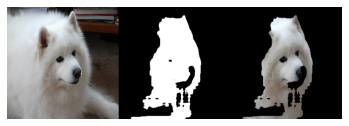

예측: 1
[[0.11712831 0.8828717 ]]
정답 :1


In [54]:
img_name = "samoyed_107.jpg"

img = cv2.imread(os.path.join("images", img_name))
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
img = img / 255.

# predict the mask 
pred = cs_model.predict(np.expand_dims(img, 0))

# mask post-processing 
msk = pred[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

# show the mask and the segmented image
img = img.astype(np.float32) 
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
combined = np.concatenate([rgb_img, msk, rgb_img * msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# 0:Cat 1:Dog
print("예측: {}".format(np.argmax(pred[1])))
print(pred[1])

# 기존 코드 Cat : -1, Dog : 0 으로 되어 있어 수정 했습니다. 
# print("정답 :{}".format(q3_dict[img_name[:-4]]-1))
print("정답 :{}".format(q3_dict[img_name[:-4]]))

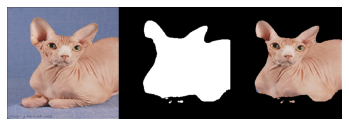

예측: 0
[[0.7503535  0.24964646]]
정답 :0


In [55]:
img_name = "Sphynx_180.jpg"

img = cv2.imread(os.path.join("images", img_name))
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
img = img / 255.

# predict the mask 
pred = cs_model.predict(np.expand_dims(img, 0))

# mask post-processing 
msk = pred[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

# show the mask and the segmented image
img = img.astype(np.float32) 
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
combined = np.concatenate([rgb_img, msk, rgb_img * msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# 0:Cat 1:Dog
print("예측: {}".format(np.argmax(pred[1])))
print(pred[1])

# 기존 코드 Cat : -1, Dog : 0 으로 되어 있어 수정 했습니다.
#print("정답 :{}".format(q3_dict[img_name[:-4]]-1))
print("정답 :{}".format(q3_dict[img_name[:-4]]))

In [42]:
msk

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)